<a href="https://colab.research.google.com/github/Farah-X/cardboard-box-detection/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

### Configure API keys

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["rf-detr-test"] = userdata.get("rf-detr-test")
os.environ["rf_kUGz2TXPBWTOlw2g57e9mLiOE8Y2"] = userdata.get("rf_kUGz2TXPBWTOlw2g57e9mLiOE8Y2")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu May 15 18:05:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

In [3]:
!pip install -q rfdetr==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

### Download example data

In [4]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

rf-detr-base.pth: 100%|██████████| 355M/355M [00:03<00:00, 107MiB/s]
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights


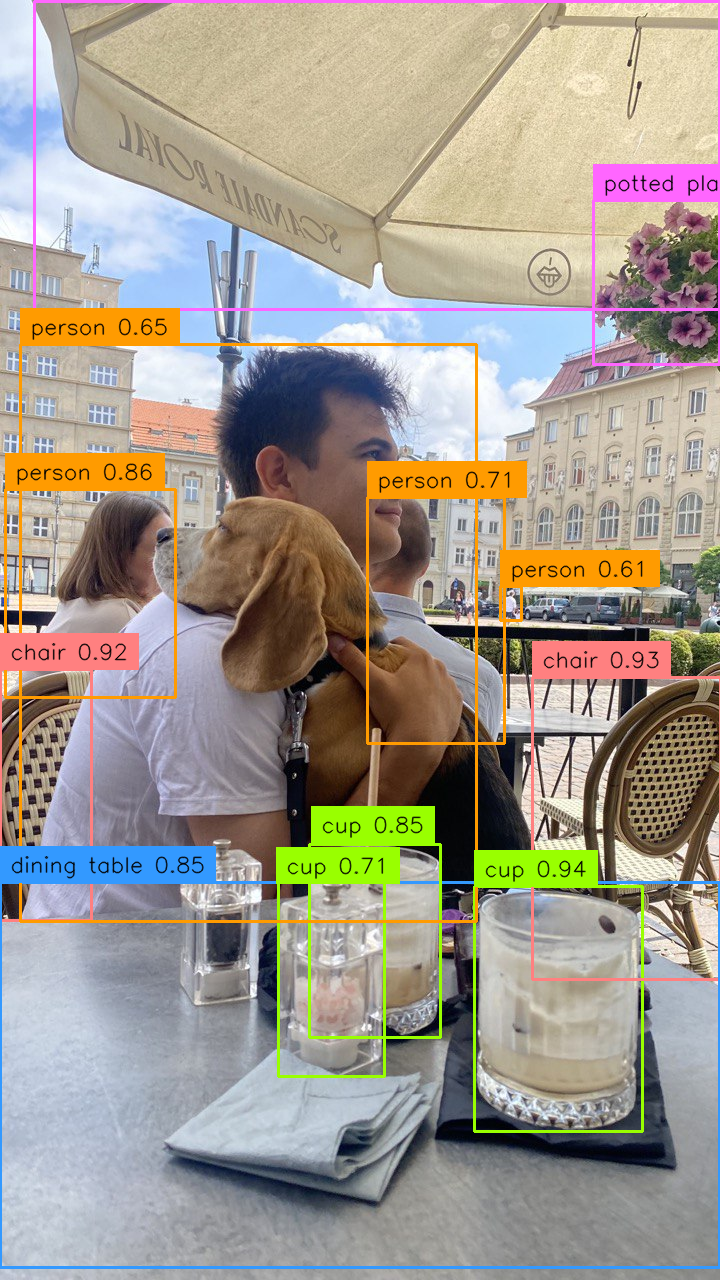

In [5]:
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image

image = Image.open("dog-2.jpeg")

model = RFDETRBase()
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image

## Download dataset from Roboflow Universe

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="85vjr4P0cLHMtLWlIbze")
project = rf.workspace("frh").project("cardboard-box-defect-qkrrj")
version = project.version(10)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cardboard-Box-Defect-10 in coco:: 100%|██████████| 7410/7410 [00:01<00:00, 4944.12it/s]


## Model train 1

In [7]:
from rfdetr import RFDETRBase

model = RFDETRBase()

model.train(dataset_dir=dataset.location, epochs=100, batch_size=16, grad_accum_steps=1, lr=1e-4)

Loading pretrain weights


reinitializing your detection head with 4 classes.


Streaming output truncated to the last 5000 lines.
Epoch: [44]  [400/435]  eta: 0:00:20  lr: 0.000100  class_error: 0.00  loss: 4.8647 (4.9071)  loss_ce: 0.5014 (0.4958)  loss_bbox: 0.2879 (0.2883)  loss_giou: 0.3122 (0.3269)  loss_ce_0: 0.6060 (0.5747)  loss_bbox_0: 0.3030 (0.2928)  loss_giou_0: 0.3209 (0.3305)  loss_ce_1: 0.5200 (0.5118)  loss_bbox_1: 0.2983 (0.2894)  loss_giou_1: 0.3058 (0.3282)  loss_ce_enc: 0.6834 (0.6525)  loss_bbox_enc: 0.3978 (0.4127)  loss_giou_enc: 0.4025 (0.4036)  loss_ce_unscaled: 0.5014 (0.4958)  class_error_unscaled: 0.0000 (0.4951)  loss_bbox_unscaled: 0.0576 (0.0577)  loss_giou_unscaled: 0.1561 (0.1634)  cardinality_error_unscaled: 2392.8125 (2551.9238)  loss_ce_0_unscaled: 0.6060 (0.5747)  loss_bbox_0_unscaled: 0.0606 (0.0586)  loss_giou_0_unscaled: 0.1604 (0.1652)  cardinality_error_0_unscaled: 2004.0000 (2261.7300)  loss_ce_1_unscaled: 0.5200 (0.5118)  loss_bbox_1_unscaled: 0.0597 (0.0579)  loss_giou_1_unscaled: 0.1529 (0.1641)  cardinality_error_1_u

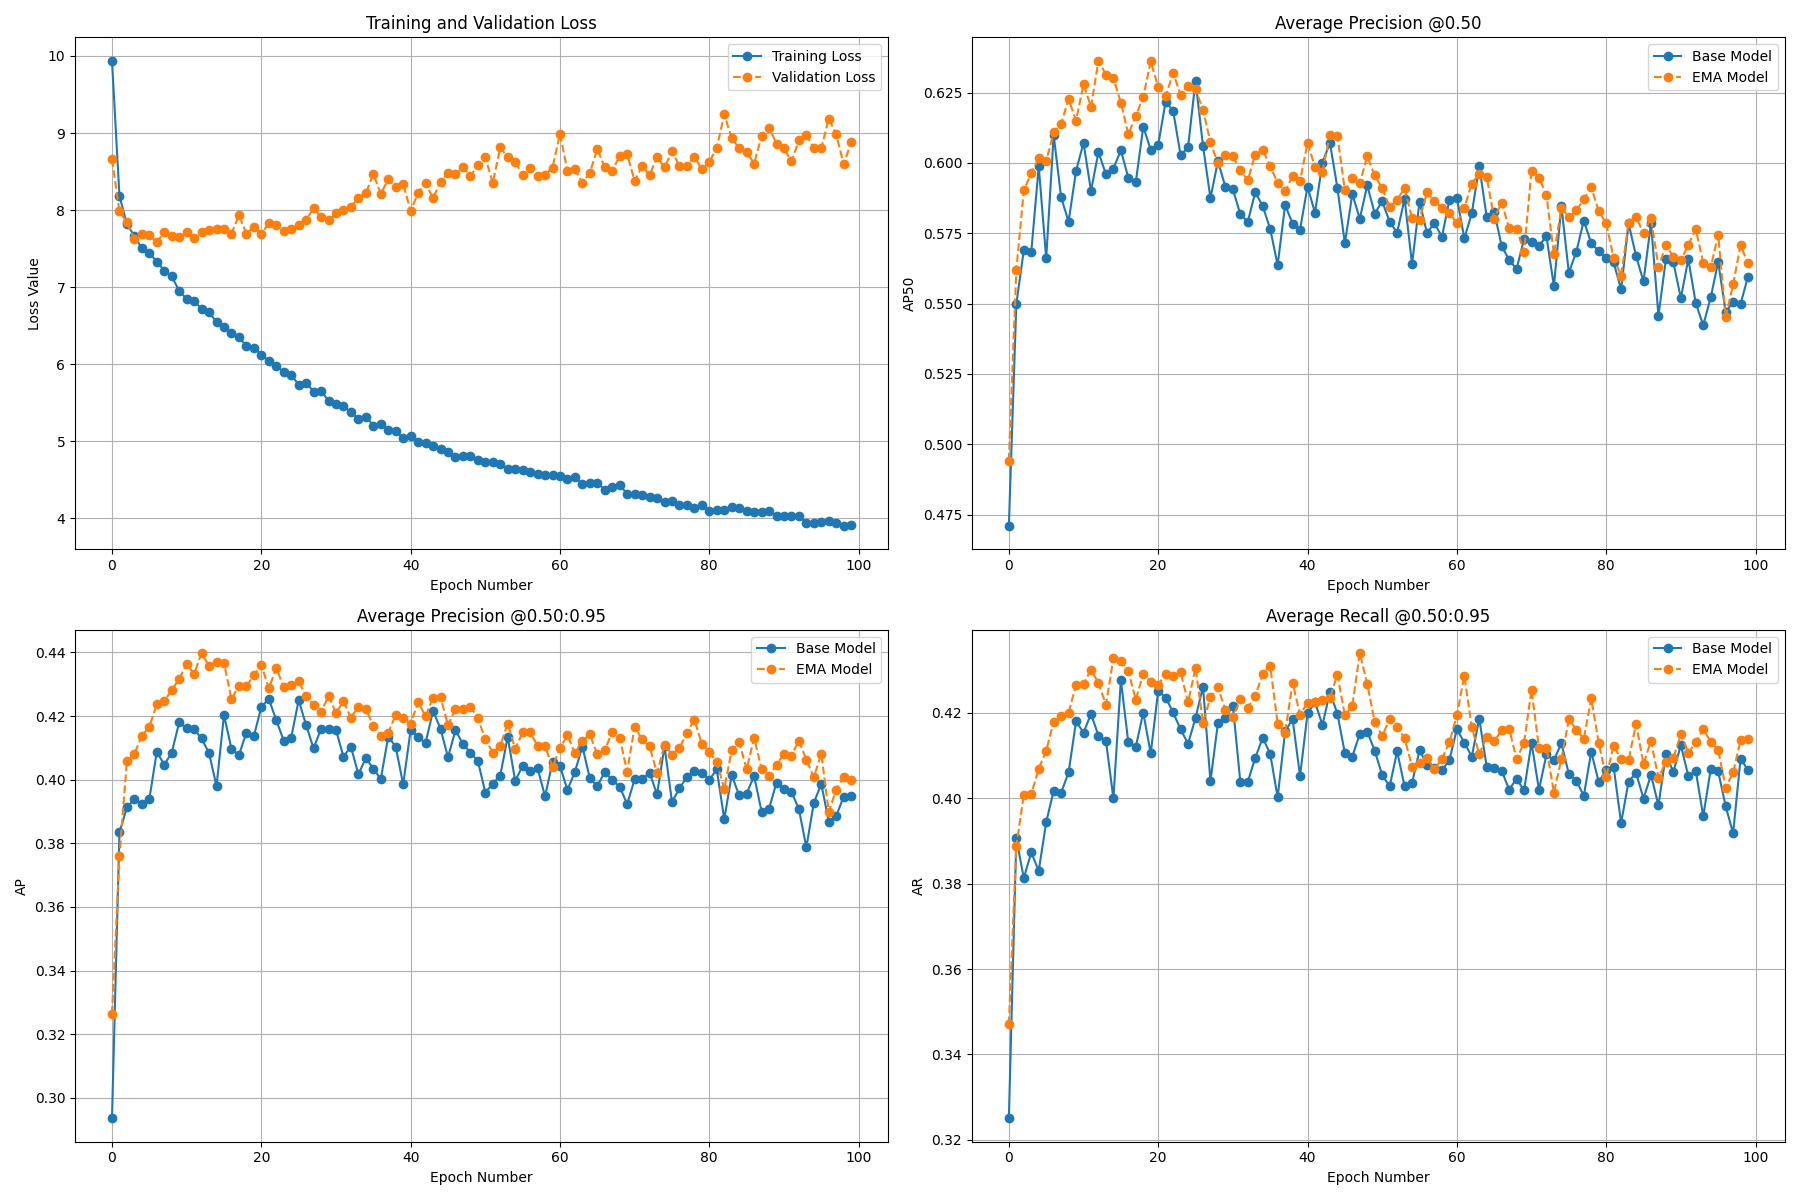

In [11]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

## Run inference with fine-tuned model

In [9]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

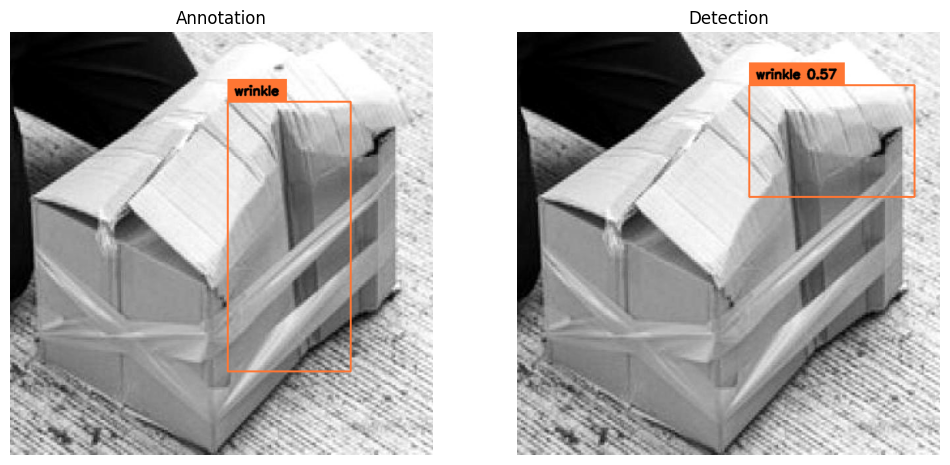

In [10]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

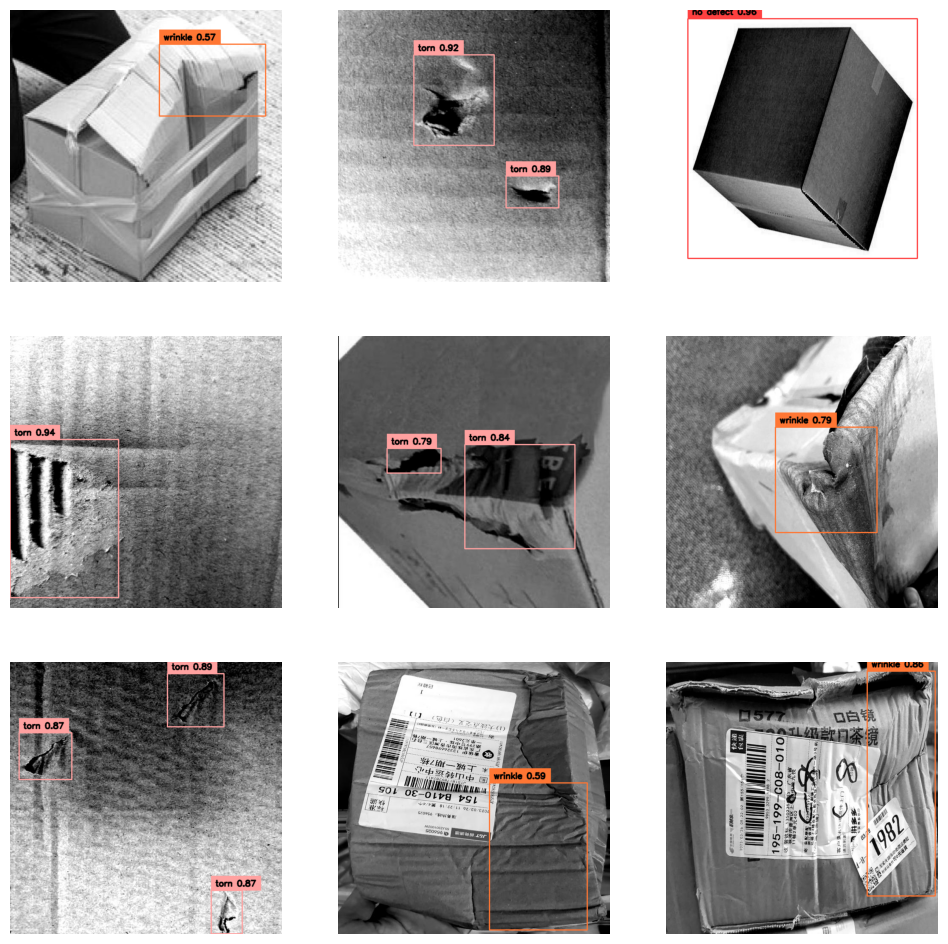

In [12]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate fine-tuned model (box defect detection)


In [13]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 141/141 [00:04<00:00, 29.92it/s]


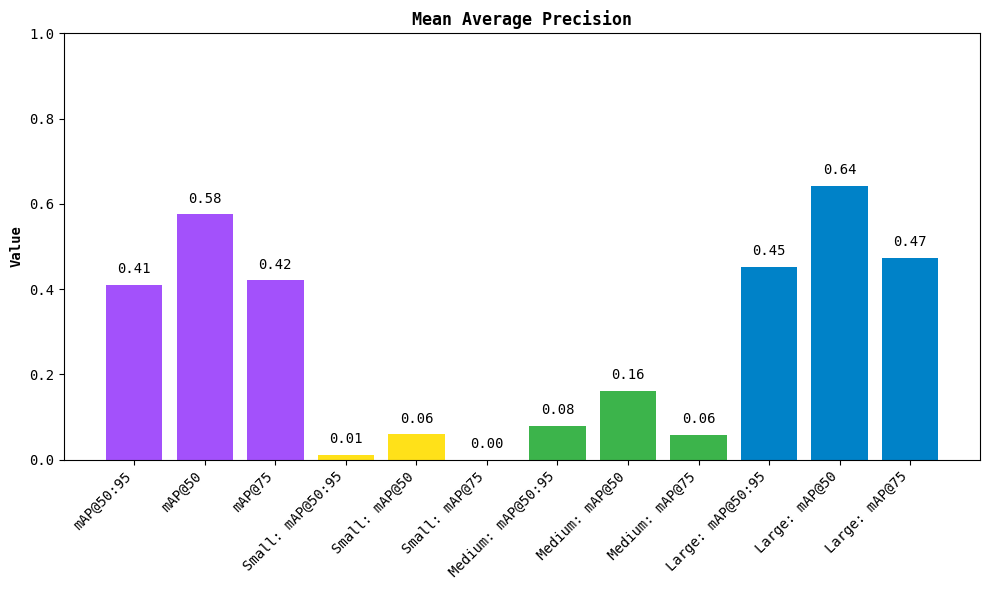

In [14]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

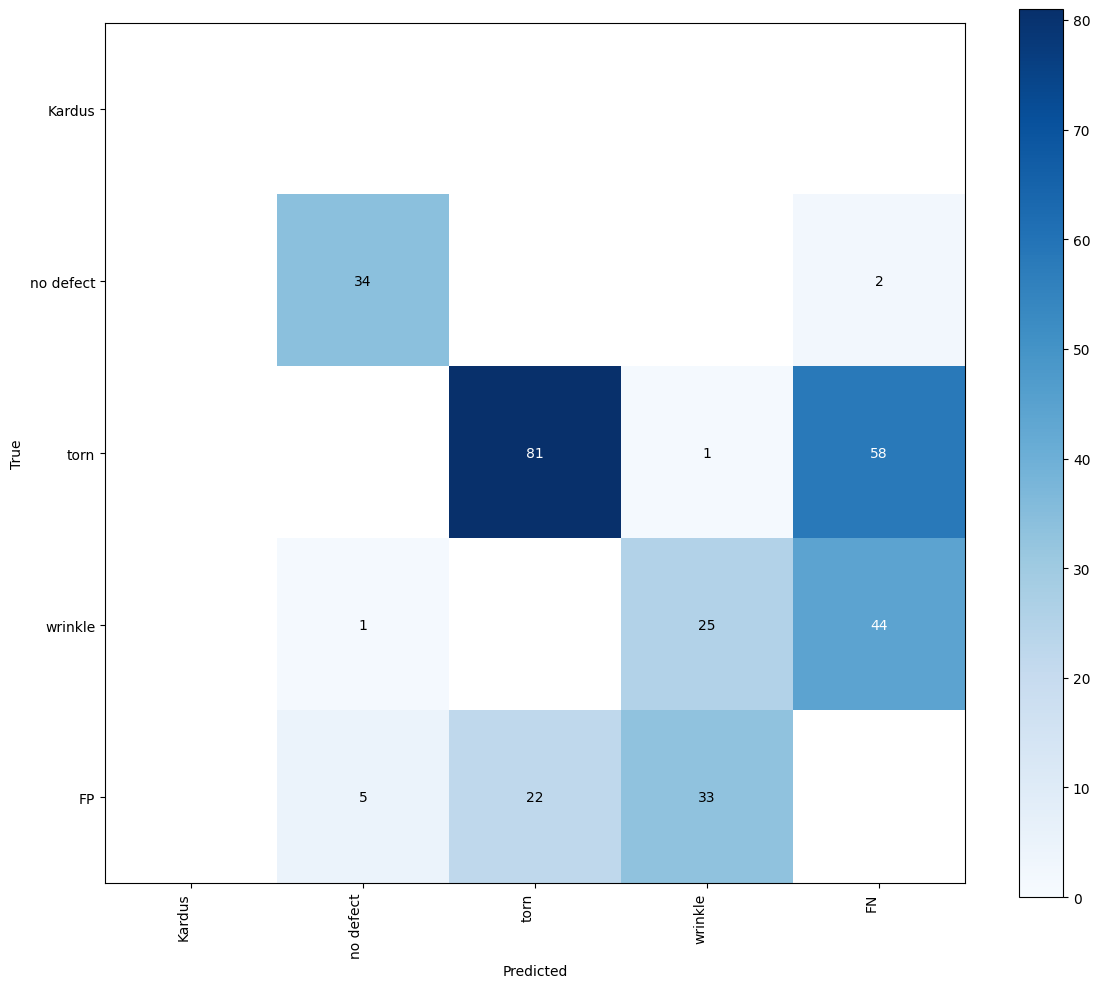

In [15]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot()

In [16]:
import supervision as sv
from tqdm import tqdm
from PIL import Image
from supervision.metrics import MeanAveragePrecision

# Initialize the evaluator
evaluator = MeanAveragePrecision()

# Iterate through your dataset
for path, image, annotations in tqdm(ds):
    image = Image.open(path)

    # Predict with your trained model
    results = model.predict(image, threshold=0.5)  # Replace with your own prediction function

    # Convert your predictions and ground truth to Detection format if needed
    predicted_detections = sv.Detections.from_inference(results)
    ground_truth_detections = annotations  # already in sv.Detections format from dataset

    # Update evaluator
    evaluator.update(predictions=predicted_detections, groundtruth=ground_truth_detections)

# Get the final scores
metrics = evaluator.compute()

# Print key metrics
print(f"Precision: {metrics.precision:.4f}")
print(f"Recall: {metrics.recall:.4f}")
print(f"mAP@50: {metrics.map_50:.4f}")

  0%|          | 0/141 [00:00<?, ?it/s]


TypeError: MeanAveragePrecision.update() got an unexpected keyword argument 'groundtruth'